# PRÀCTICA 1 - REGRESSIÓ

1597487 | Manuel Arnau Fernández

1600123 | Alba Fernández Coronado

1605547 | Marina Palomar González

## 1. Descripció de les dades

In [1]:
# Carregant les llibreries necessàries
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections as col
import scipy.stats as stats
import statsmodels.api as sm
import scipy.stats
import random as rand
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder, StandardScaler, scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Obrint el dataset
dataset = pd.read_csv('./insurance.csv')
print(f'Mida de les dades: {dataset.shape}')
dataset.head()

Mida de les dades: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Entenent els tipus de variables de cada atribut
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
# Modificant les dades fent ús de one-hot encoding per tenir-les totes numèriques
dataset_cp = pd.concat([dataset, pd.get_dummies(dataset.region, prefix='region')], axis=1)
dataset_cp = pd.concat([dataset_cp, pd.get_dummies(dataset.smoker, drop_first=True, prefix='smoker')], axis=1)
dataset_cp = pd.concat([dataset_cp, pd.get_dummies(dataset.sex, drop_first=True, prefix='is')], axis=1)
dataset_cp = dataset_cp.drop(['smoker'], axis=1)
dataset_cp = dataset_cp.drop(['sex'], axis=1)
dataset_cp = dataset_cp.drop(['region'], axis=1)
dataset_cp.head()

,age,bmi,children,charges,region_northeast,region_northwest,region_southeast,region_southwest,smoker_yes,is_male
0,19,27.900,0,16884.92400,0,0,0,1,1,0
1,18,33.770,1,1725.55230,0,0,1,0,0,1
2,28,33.000,3,4449.46200,0,0,1,0,0,1
3,33,22.705,0,21984.47061,0,1,0,0,0,1
4,32,28.880,0,3866.85520,0,1,0,0,0,1


In [5]:
# Separant el dataset en X i Y
Y = dataset_cp['charges']
X = dataset_cp.drop(['charges'], axis=1)

### ANÀLISI DELS ATRIBUTS

Southwest: 325, Southeast: 364, Northeast: 324, Northwest: 325


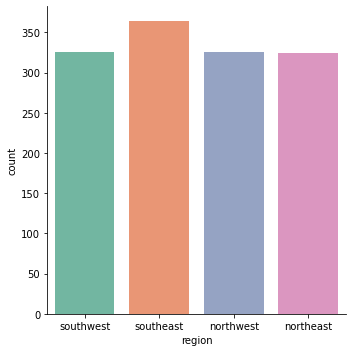

In [6]:
# Estudi de l'atribut region
sns.catplot(x = "region", data = dataset, kind = "count", palette='Set2')
count = col.Counter(dataset['region'])
sw = count['southwest']
se = count['southeast']
ne = count['northeast']
nw = count['northwest']
print(f'Southwest: {sw}, Southeast: {se}, Northeast: {ne}, Northwest: {nw}')

Zero fills: 574, Un fill: 324, Dos fills: 240, Tres fills: 157, Quatre fills: 25, Cinc fills: 18


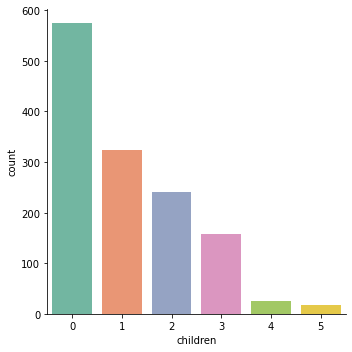

In [7]:
# Estudi de l'atribut children
sns.catplot(x = "children", data = dataset, kind = "count", palette='Set2')
count = col.Counter(dataset['children'])
z = count[0]
u = count[1]
d = count[2]
t = count[3]
q = count[4]
c = count[5]
print(f'Zero fills: {z}, Un fill: {u}, Dos fills: {d}, Tres fills: {t}, Quatre fills: {q}, Cinc fills: {c}')

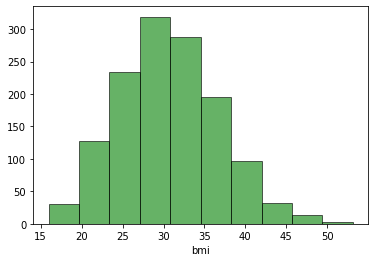

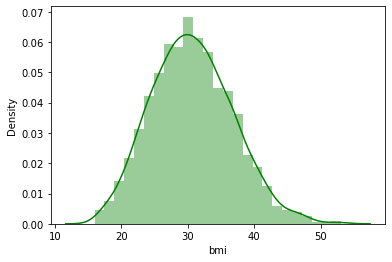

In [8]:
# Estudi de l'atribut BMI
plt.hist(dataset['bmi'], color= 'green', edgecolor = 'black', alpha = 0.6)
plt.xlabel('bmi')
plt.show()

sns.distplot(dataset['bmi'], color= 'green')

Nombre total outliers en la distribució BMI: 9.


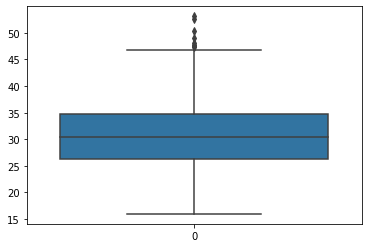

In [9]:
# Realitzant un boxplot d'aquesta variable per tal d'analitzar els outliers
sns.boxplot(dataset['bmi'])
Q1 = dataset['bmi'].quantile(0.25)
Q3 = dataset['bmi'].quantile(0.75)
IQR = Q3 - Q1
total_outlier_num = ((dataset['bmi'] < (Q1 - 1.5 * IQR)) | (dataset['bmi'] > (Q3 + 1.5 * IQR))).sum()
print(f'Nombre total outliers en la distribució BMI: {total_outlier_num}.')

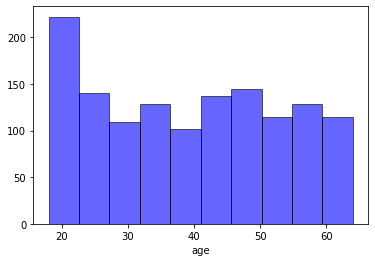

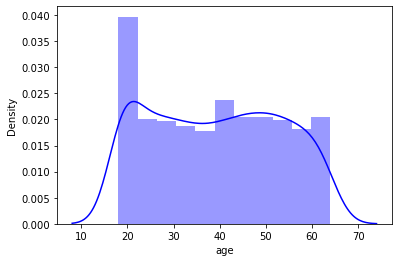

In [10]:
# Estudi de l'atribut age
plt.hist(dataset['age'], color= 'blue', edgecolor = 'black', alpha = 0.6)
plt.xlabel('age')
plt.show()

sns.distplot(dataset['age'], color= 'blue')

Homes: 676, Dones: 662


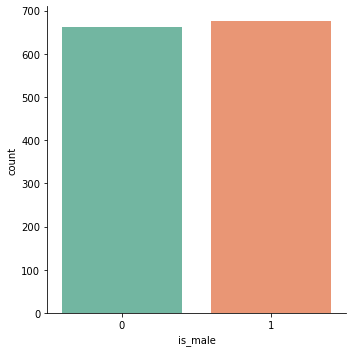

In [11]:
# Estudi de l'atribut sex (0 = dona, 1 = home)
sns.catplot(x = "is_male", data = X, kind = "count", palette='Set2')
count = col.Counter(X['is_male'])
female = count[0]
male = count[1]
print(f'Homes: {male}, Dones: {female}')

No fumadors: 1064, Fumadors: 274


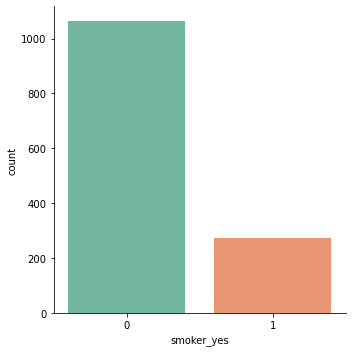

In [12]:
# Estudi de l'atribut smoker (0 = no fumador, 1 = fumador)
sns.catplot(x = "smoker_yes", data = X, kind = "count", palette='Set2')
count = col.Counter(X['smoker_yes'])
no_s = count[0]
s = count[1]
print(f'No fumadors: {no_s}, Fumadors: {s}')

### INFORMACIÓ DE LA VARIABLE RESPOSTA

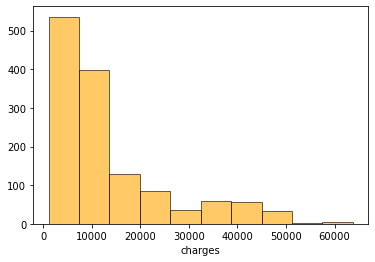

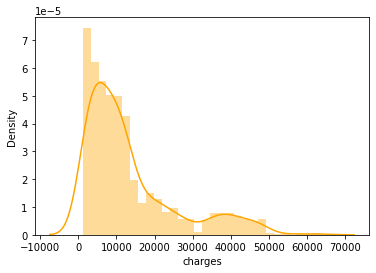

In [13]:
# Estudi de la variable resposta, charges
plt.hist(Y, color= 'orange', edgecolor = 'black', alpha = 0.6)
plt.xlabel('charges')
plt.show()
sns.distplot(Y, color= 'orange')

Nombre total outliers en la distribució CHARGES: 139.


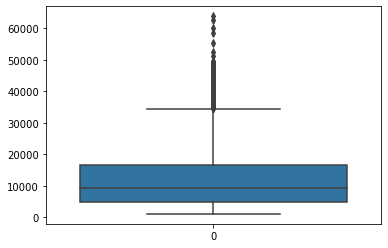

In [35]:
# Realitzant un boxplot d'aquesta variable per tal d'analitzar els outliers
sns.boxplot(Y)
Q1 = Y.quantile(0.25)
Q3 = Y.quantile(0.75)
IQR = Q3 - Q1
total_outlier_num = ((Y < (Q1 - 1.5 * IQR)) | (Y > (Q3 + 1.5 * IQR))).sum()
print(f'Nombre total outliers en la distribució CHARGES: {total_outlier_num}.')

### ANÀLISI DELS ATRIBUTS RESPECTE LA VARIABLE RESPOSTA

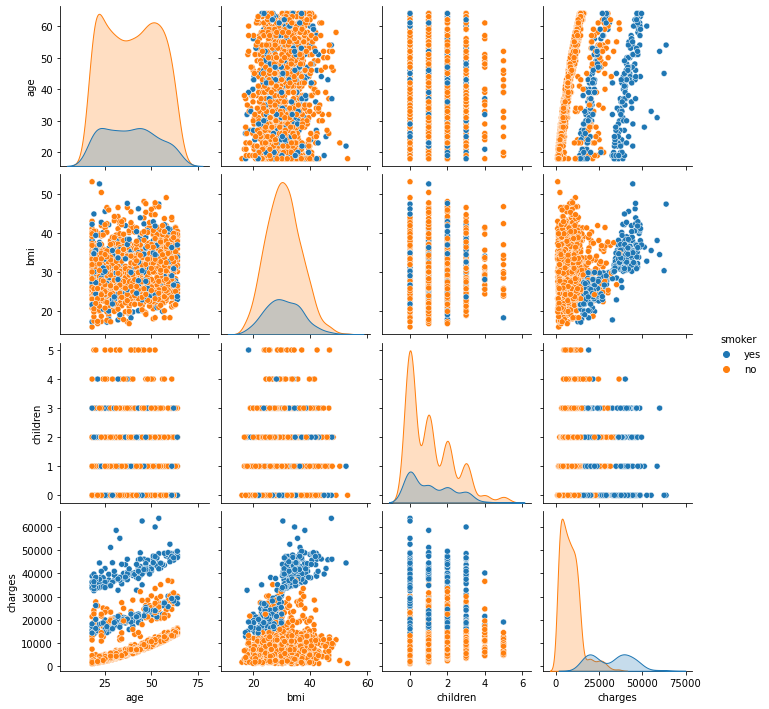

In [15]:
# Es tracen relacions per parelles d'atributs no binaris tenint en compte si fumen
sns.pairplot(dataset, hue = 'smoker')

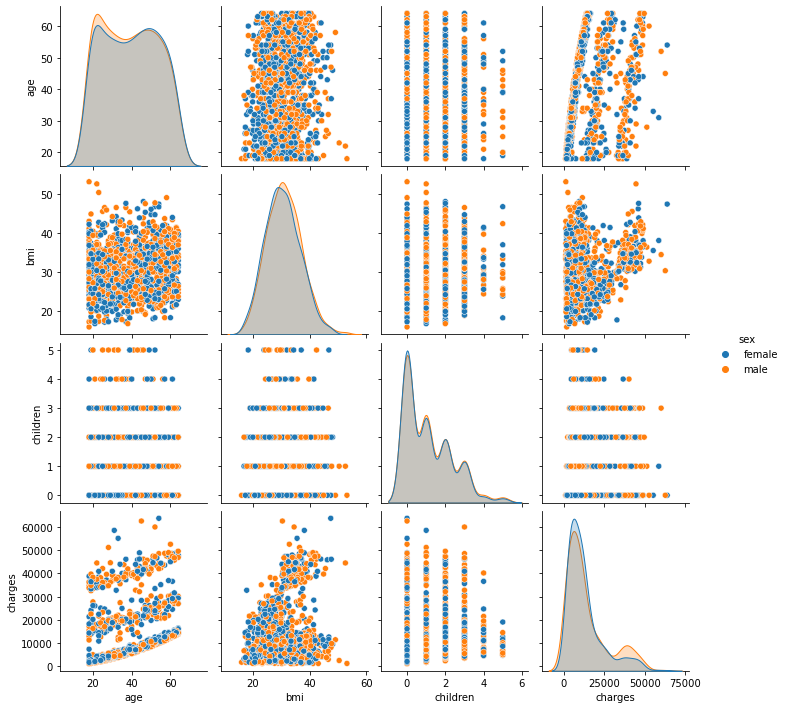

In [16]:
# Es tracen relacions per parelles d'atributs no binaris tenint en compte el gènere
sns.pairplot(dataset, hue = 'sex')

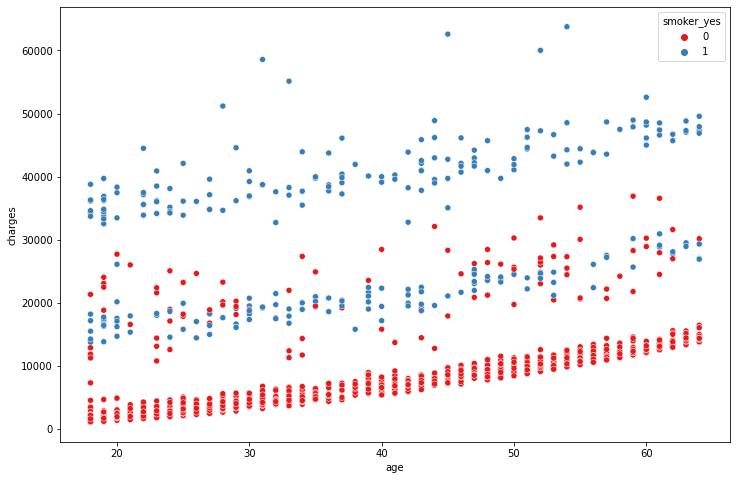

In [17]:
# Comparació edat i preus segons si són fumadors
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.scatterplot(x = 'age', y = 'charges', hue='smoker_yes', data=dataset_cp, palette='Set1')

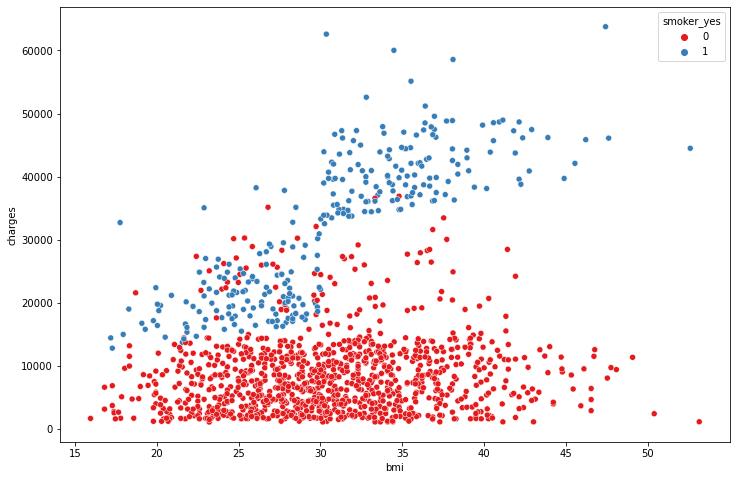

In [18]:
# Comparació bmi i preus segons si són fumadors
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.scatterplot(x = 'bmi', y = 'charges', hue='smoker_yes', data=dataset_cp, palette='Set1')

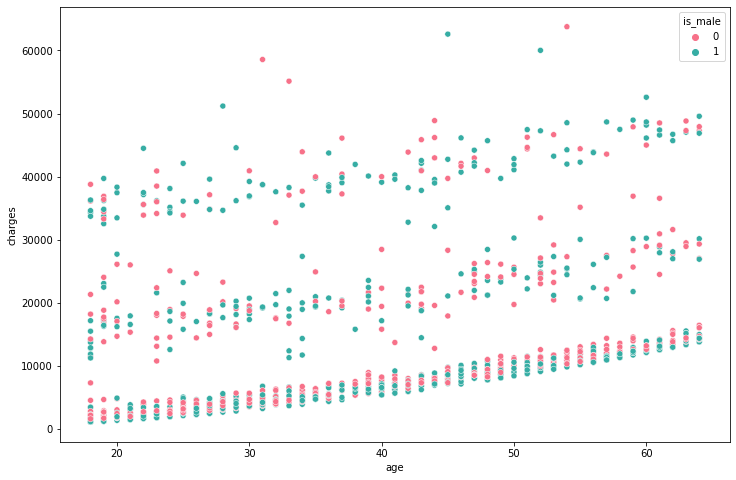

In [19]:
# Comparació edat i preu segons sexe
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.scatterplot(x = 'age', y = 'charges', hue='is_male', data=dataset_cp, palette='husl')

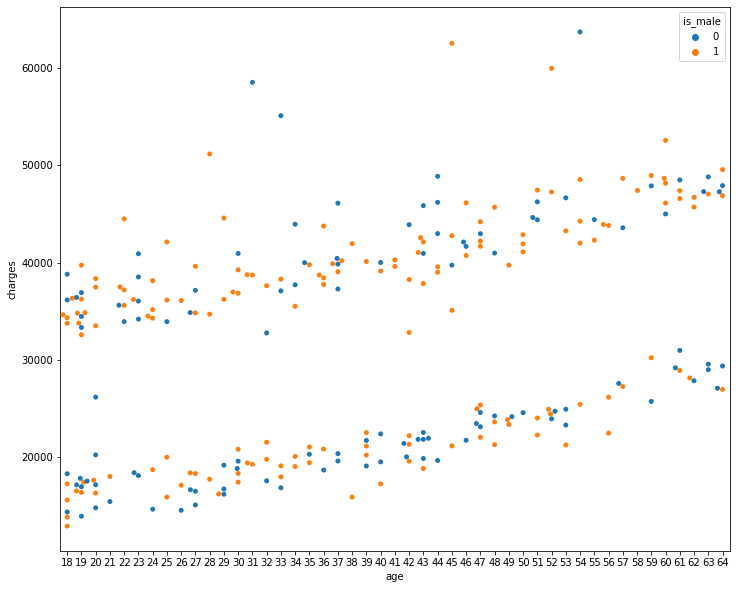

In [20]:
# Còpia de les dades de fumadors a un altre dataset
fumadors = dataset_cp[dataset_cp['smoker_yes'] == 1].copy()

# Comparació de charges respecte el gènere
plt.figure(figsize=(12,10))
sns.swarmplot(y='charges',x='age', hue='is_male',data=fumadors)
plt.show()

In [21]:
# Realització d'un t-test per validar una hipòtesi
H0 = "els homes fumadors paguen més que les dones fumadores"
H1 = "els homes fumadors no paguen més que les dones fumadores"

h = fumadors[fumadors.is_male == 1]['charges']
d = fumadors[fumadors.is_male == 0]['charges']

# Aplicació del test Anova per comparar múltiples mitjanes
f_stat, p_valor = stats.f_oneway(h,d)

if(p_valor<0.05):
    print(f'{p_valor} -> Es rebutja la hipòtesi nul·la, per tant {H1}')
else:
    print(f'{p_valor} -> No es rebutja la hipòtesi nul·la, per tant {H0}') 

0.0944795303099132 -> No es rebutja la hipòtesi nul·la, per tant els homes fumadors paguen més que les dones fumadores


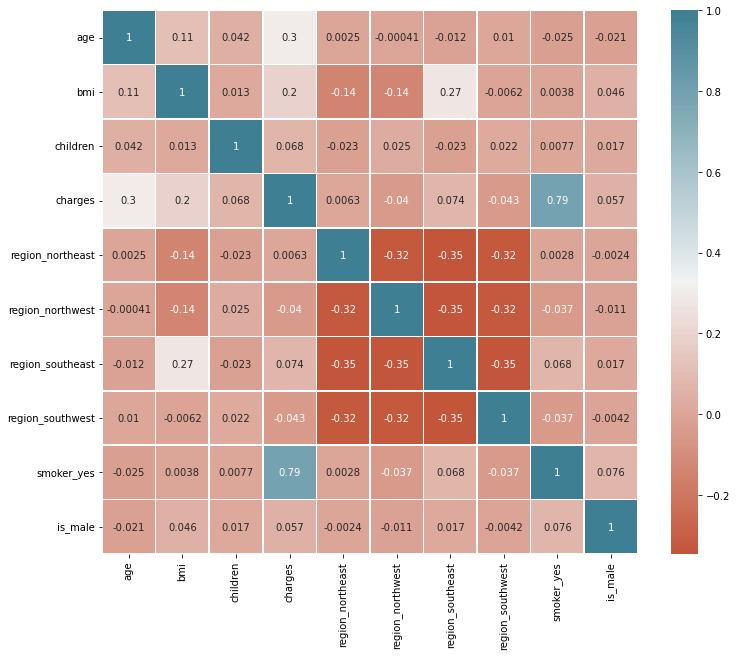

In [22]:
# Estudi de la correlació entre els atributs
correlacio = dataset_cp.corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(correlacio, annot=True, linewidths=.5, cmap = sns.diverging_palette(20, 220, n=200))

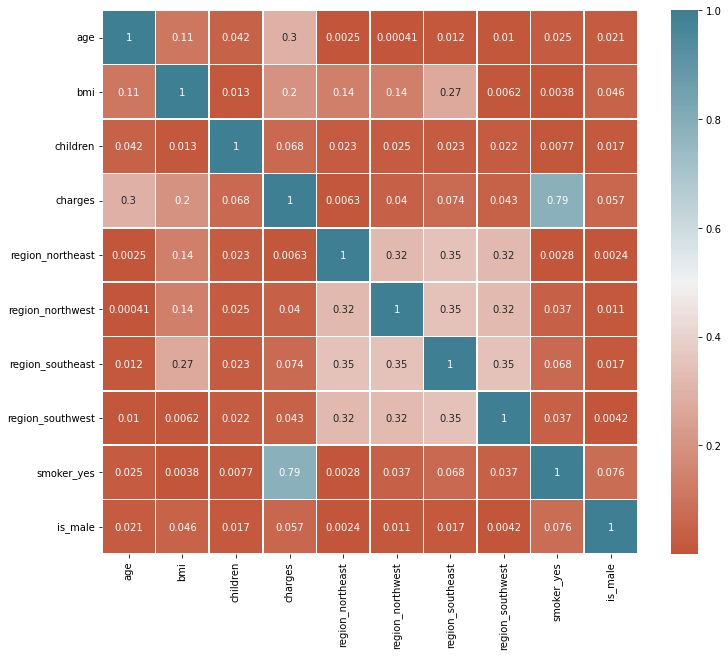

In [23]:
# Es fa el heatmap en valor absolut per veure més clarament les correlacions entre les variables
# El que interessa és saber si les variables estan correlacionades o no, no si ho estan positiva o negativament
correlacio = dataset_cp.corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(abs(correlacio), annot=True, linewidths=.5, cmap = sns.diverging_palette(20, 220, n=200))

## 2. Primeres regressions

In [24]:
# Funció per normalitzar les dades
def standarize(xtrain):
    mean = xtrain.mean(0)
    std = xtrain.std(0)
    x_t = xtrain - mean[None, :]
    x_t /= std[None, :]
    return x_t

In [25]:
# Es faràn dos models de regressió depenent de si l'usuari es fumador o no, per tant es separa el dataset
fumadors = dataset_cp[dataset_cp['smoker_yes'] == 1].copy()
nofumadors = dataset_cp[dataset_cp['smoker_yes'] == 0].copy()
fumadors = fumadors.drop(['smoker_yes'], axis=1)
nofumadors = nofumadors.drop(['smoker_yes'], axis=1)

fy = fumadors['charges']
nfy = nofumadors['charges']
fumadors = fumadors.drop(['charges'], axis=1)
nofumadors = nofumadors.drop(['charges'], axis=1)

fnorm = standarize(fumadors)
nfnorm = standarize(nofumadors)

In [26]:
# Es separen les dades de train i test per ambdós models
XF_train, XF_test, YF_train, YF_test = train_test_split(fnorm, fy, test_size=0.3, random_state=99)
XNF_train, XNF_test, YNF_train, YNF_test = train_test_split(nfnorm, nfy, test_size=0.3, random_state=99)

#### REGRESSIONS SIMPLES

In [29]:
def RegressioSimple(atribut, Xtrain, Ytrain, Xtest, Ytest):
    # Es fa la regressió amb el lm i fit
    lm = LinearRegression()
    np_data=Xtrain[atribut].to_numpy()
    x = np_data.reshape(-1,1)
    model = lm.fit(x,Ytrain)
    
    m = np.linspace(Xtest[atribut].min(), Xtest[atribut].max(), 100)
    r = [model.coef_ * i + model.intercept_ for i in m]
    
    # Es prediu la variable resposta
    pred = model.coef_ * Xtest[atribut] + model.intercept_ 
    
    # Vector d'errors
    e = Ytest-pred   

    MSE = mean_squared_error(Ytest, pred)
    r2 = r2_score(Ytest, pred)
    
    # Es grafiquen els resultats
    fig = plt.figure(figsize=(12,10))
    gs = gridspec.GridSpec(2, 2)

    ax = fig.add_subplot(gs[0, :])
    sns.scatterplot(y=Ytest,x=Xtest[atribut], hue='is_male', legend=['1','0'],data=Xtest, palette='Set1')
    plt.plot(m, r, 'r')

    ax = fig.add_subplot(gs[1, 0])
    ax.scatter(Ytest,pred)
    ax.set_xlabel('Y')
    ax.set_ylabel('Ypred')
    ax.tick_params(axis='x', rotation=55)

    ax = fig.add_subplot(gs[1, 1])
    ax.scatter(Ytest,e)
    ax.set_xlabel('Y')
    ax.set_ylabel('Error')

    fig.align_labels()

    plt.show()

    print("Mean squeared error: ", MSE)
    print("R2 score: ", r2)

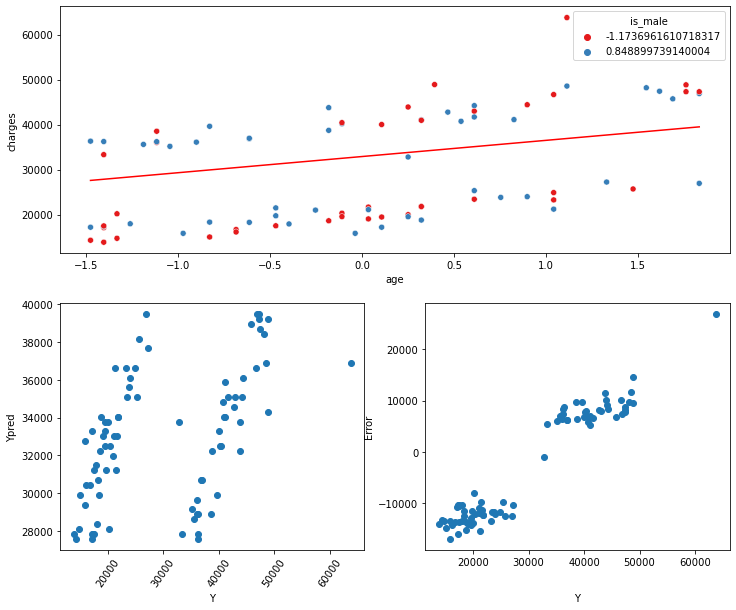

Mean squeared error:  124901946.6588159
R2 score:  0.13828303102393613


In [30]:
# Regressió de l'atribut age tenint en compte el sexe (vermell = home, blau = dona) sabent que són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('age', XF_train, YF_train, XF_test, YF_test)

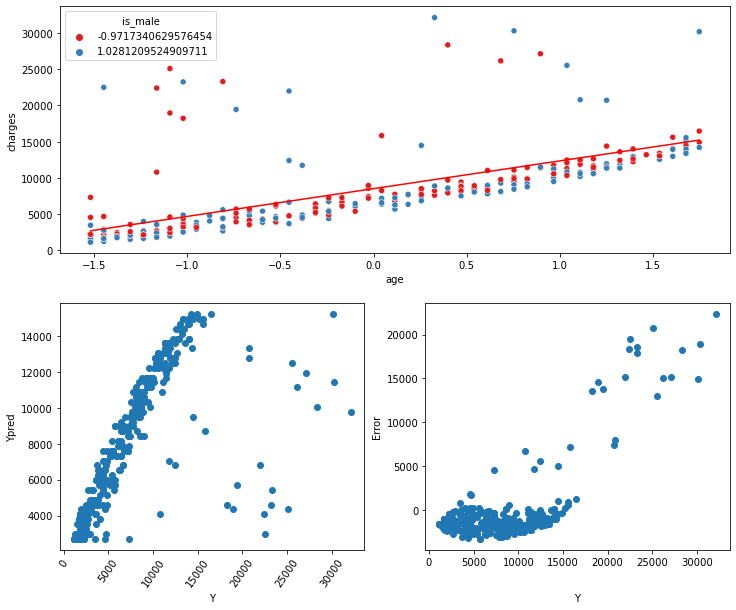

Mean squeared error:  18095495.548921674
R2 score:  0.41971239627836576


In [31]:
# Regressió de l'atribut age tenint en compte el sexe (vermell = home, blau = dona) sabent que no són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('age', XNF_train, YNF_train, XNF_test, YNF_test)

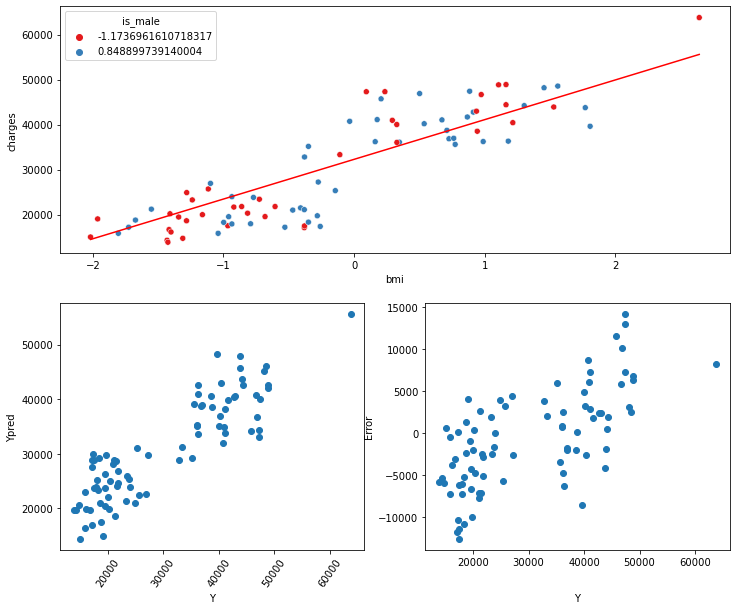

Mean squeared error:  34424452.843412906
R2 score:  0.7625006178333135


In [32]:
# Regressió de l'atribut bmi tenint en compte el sexe (vermell = home, blau = dona) sabent que són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('bmi', XF_train, YF_train, XF_test, YF_test)

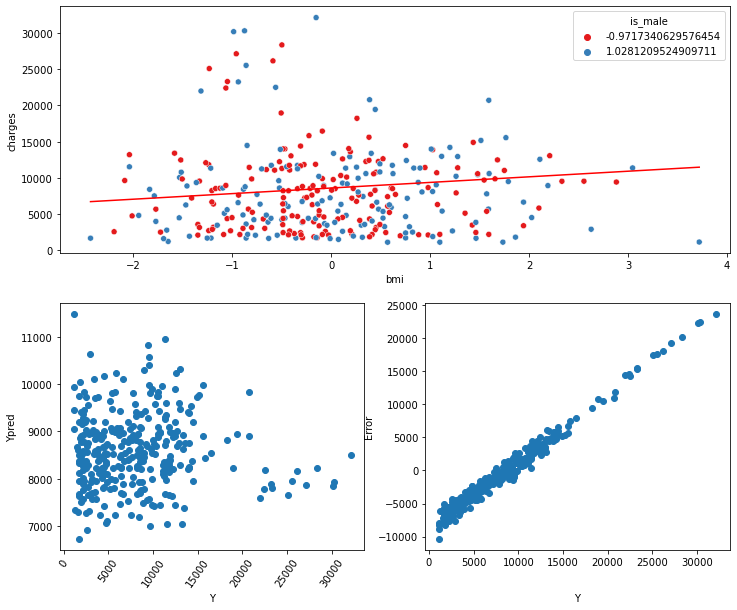

Mean squeared error:  32284086.48269413
R2 score:  -0.03528831983277514


In [33]:
# Regressió de l'atribut bmi tenint en compte el sexe (vermell = home, blau = dona) sabent que no són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('bmi', XNF_train, YNF_train, XNF_test, YNF_test)

In [34]:
# Com s'ha pogut observar, el MSE és molt gran així que es fa una transformació logaritmica sobre la resposta
fylog = np.log(fy)
nfylog = np.log(nfy)

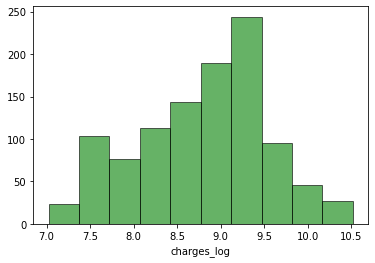

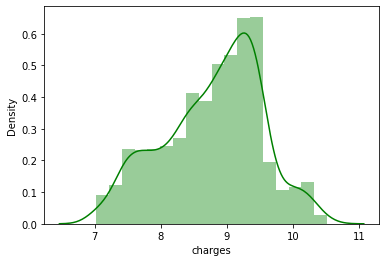

In [36]:
# Estudi de la variable resposta, charges
plt.hist(nfylog, color= 'green', edgecolor = 'black', alpha = 0.6)
plt.xlabel('charges_log')
plt.show()
sns.distplot(nfylog, color= 'green')

In [37]:
# Es torna a separar les dades de train i test amb la nova Y
XF_train, XF_test, YF_train, YF_test = train_test_split(fnorm, fylog, test_size=0.3, random_state=99)
XNF_train, XNF_test, YNF_train, YNF_test = train_test_split(nfnorm, nfylog, test_size=0.3, random_state=99)

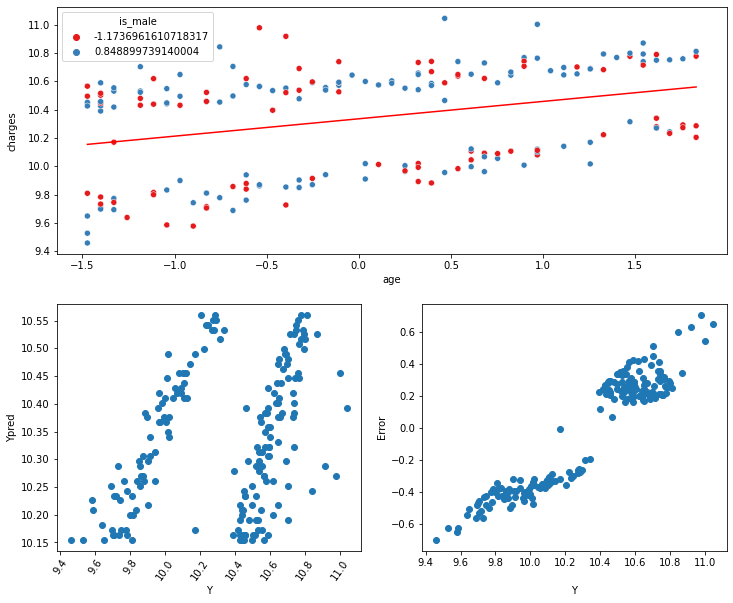

Mean squeared error:  0.12340147545184388
R2 score:  0.1108205585826475


In [38]:
# Regressió de l'atribut age tenint en compte el sexe (vermell = home, blau = dona) sabent que són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('age', XF_train, YF_train, XF_train, YF_train)

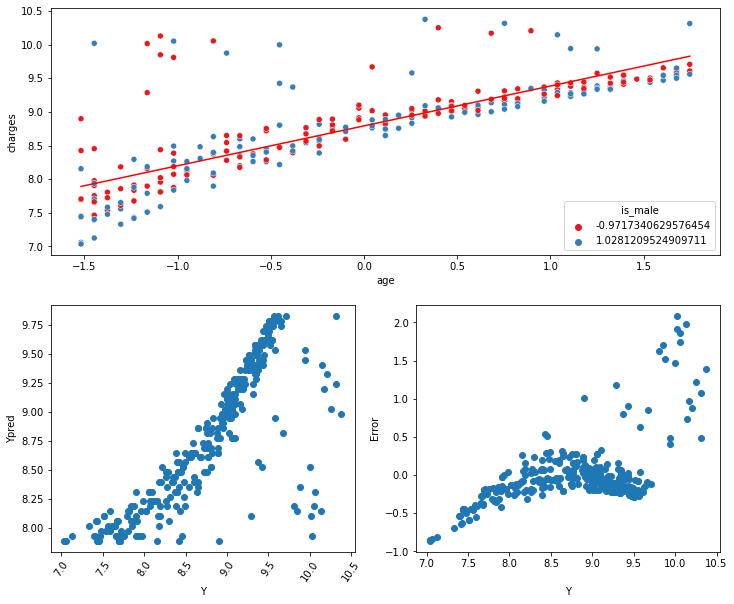

Mean squeared error:  0.18296539338612383
R2 score:  0.6581416033125622


In [39]:
# Regressió de l'atribut age tenint en compte el sexe (vermell = home, blau = dona) sabent que no són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('age', XNF_train, YNF_train, XNF_test, YNF_test)

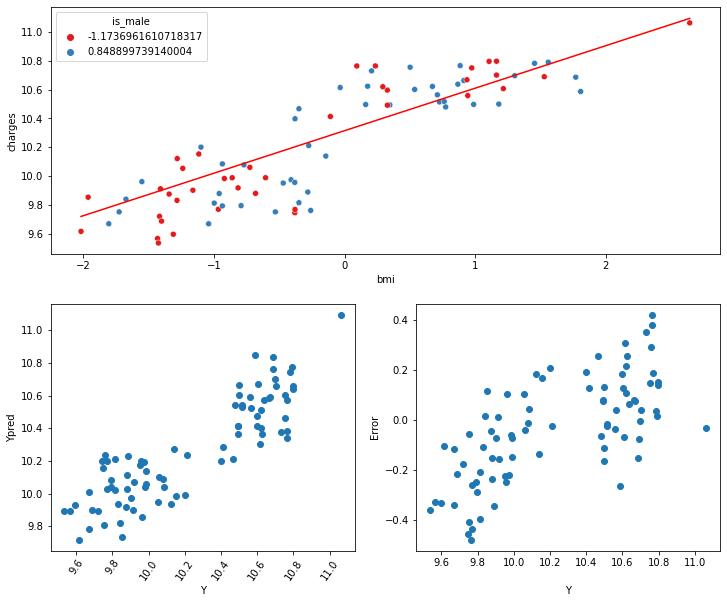

Mean squeared error:  0.04318248617755908
R2 score:  0.7416933350558413


In [40]:
# Regressió de l'atribut bmi tenint en compte el sexe (vermell = home, blau = dona) sabent que són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('bmi', XF_train, YF_train, XF_test, YF_test)

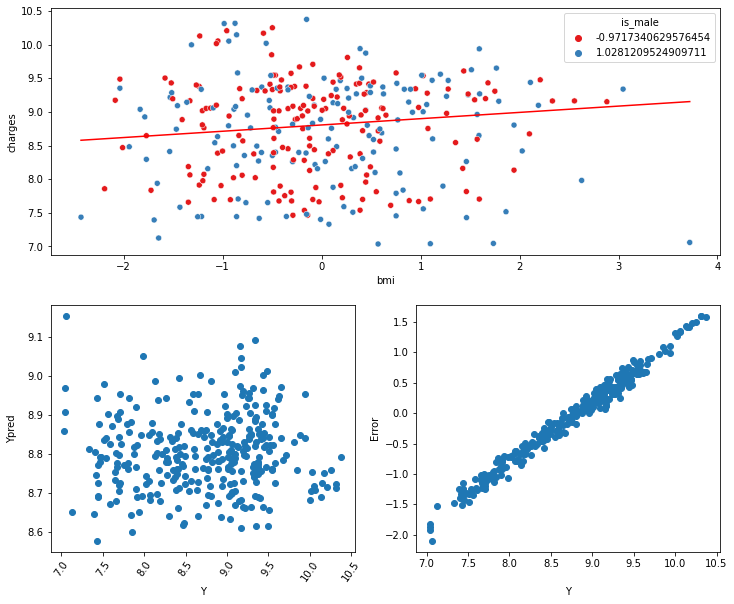

Mean squeared error:  0.5456084268138688
R2 score:  -0.019432246491101646


In [41]:
# Regressió de l'atribut bmi tenint en compte el sexe (vermell = home, blau = dona) sabent que no són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('bmi', XNF_train, YNF_train, XNF_test, YNF_test)

#### REGRESSIONS MÚLTIPLES

In [42]:
# Realitzant una regressió lineal amb lm sobre el dataset de fumadors
lmF = LinearRegression()
modelFumadors = lmF.fit(XF_train,YF_train)
predFumadors = lmF.predict(XF_test) 
pd.DataFrame(modelFumadors.coef_, fumadors.columns, columns=["Coeff"])

,Coeff
age,0.122115
bmi,0.302756
children,-0.003997
region_northeast,0.010059
region_northwest,0.005667
region_southeast,-0.021924
region_southwest,0.009026
is_male,0.000398


In [43]:
print('intercept:',modelFumadors.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(YF_test, predFumadors))
print('Coefficient of determination (R^2): %.2f'% r2_score(YF_test, predFumadors))

intercept: 10.316357031920287
Mean squared error (MSE): 0.03
Coefficient of determination (R^2): 0.84


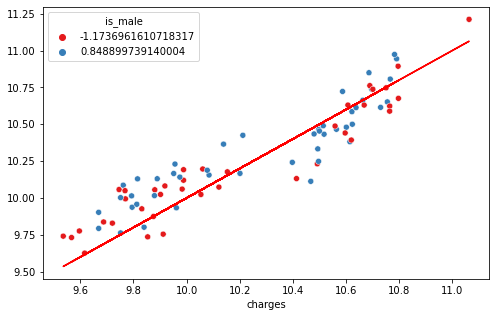

In [44]:
# Es grafiquen Ypred-Y tenint en compte el sexe sabent que són fumadors
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=predFumadors,x=YF_test, hue='is_male',data=XF_test, palette='Set1')
plt.plot(YF_test, YF_test, 'r') # recta amb pendent 1, per veure com de bona es ypred
plt.show()

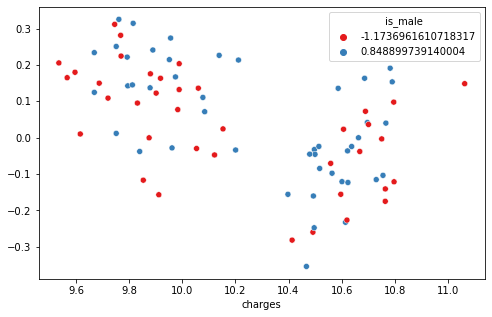

In [45]:
# Es grafiquen Error-Y tenint en compte el sexe sabent que són fumadors
ErrorF = list(predFumadors - YF_test)
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=ErrorF,x=YF_test, hue='is_male',data=XF_test, palette='Set1')
plt.show()

In [47]:
# Realitzant una regressió lineal amb lm sobre el dataset de no fumadors
lmNF = LinearRegression()
modelNoFumadors = lmNF.fit(XNF_train,YNF_train)
predNoFumadors = lmNF.predict(XNF_test)
pd.DataFrame(modelNoFumadors.coef_, nofumadors.columns, columns=["Coeff"])

,Coeff
age,0.579605
bmi,0.034551
children,0.160532
region_northeast,0.046543
region_northwest,0.018731
region_southeast,-0.028428
region_southwest,-0.036043
is_male,-0.053813


In [48]:
print('intercept:',modelNoFumadors.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(YNF_test, predNoFumadors))
print('Coefficient of determination (R^2): %.2f'% r2_score(YNF_test, predNoFumadors))

intercept: 8.797546297867141
Mean squared error (MSE): 0.16
Coefficient of determination (R^2): 0.71


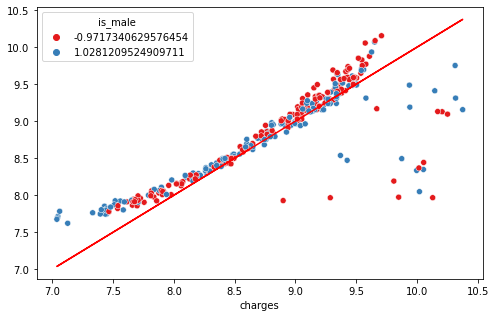

In [49]:
# Es grafiquen Ypred-Y tenint en compte el sexe sabent que són no fumadors
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=predNoFumadors,x=YNF_test, hue='is_male',data=XNF_test, palette='Set1')
plt.plot(YNF_test, YNF_test, 'r')
plt.show()

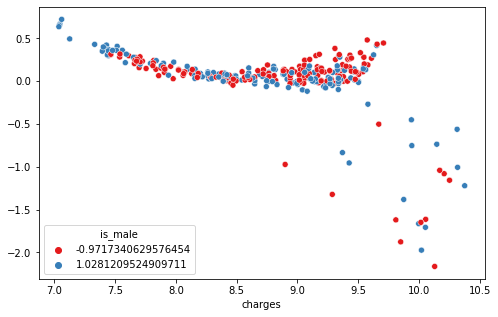

In [50]:
# Es grafiquen Error-Y tenint en compte el sexe sabent que són no fumadors
ErrorNF = list(predNoFumadors - YNF_test)
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=ErrorNF,x=YNF_test, hue='is_male',data=XNF_test, palette='Set1')
plt.show()

In [53]:
# Es realitza una altra regressió múltiple per quedar-se amb els atributs més influents
def RegressioMultiple(Xtrain, Ytrain,it=0):
    if(it == 0):
        # Afegeix intercept al model
        Xtrain = sm.add_constant(Xtrain)
        it = it + 1
    # Realitzant una regressió lineal amb OLS
    model = sm.OLS(Ytrain,Xtrain)
    resultat = model.fit()
    if resultat.pvalues.max() > 0.05:
        resultat = BWSelection(it,resultat, Xtrain, Ytrain)
    return(resultat)

In [54]:
# Es realitza un backward Selection
def BWSelection(it,resultat, Xtrain, Ytrain):
    index = list(resultat.pvalues).index(resultat.pvalues.max())
    Xtrain = Xtrain.drop(Xtrain.columns[index], axis=1)
    res = RegressioMultiple(Xtrain, Ytrain,it)
    return(res)

In [55]:
FMultiple = RegressioMultiple(XF_train, YF_train)
NFMultiple = RegressioMultiple(XNF_train, YNF_train)

In [56]:
FMultiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     148.0
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.75e-49
Time:                        20:55:23   Log-Likelihood:                 33.739
No. Observations:                 191   AIC:                            -59.48
Df Residuals:                     187   BIC:                            -46.47
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.3163      0.015    693.758      0.000      10.287      10.346
age                  0.1215      0.015      8.287      0.000       0.093       0.150
bmi                  0.3030      0.016     19.071      0.000       0.272       0.334
region_southeast    -0.0313      0.015     -2.053      0.041      -0.061      -0.001
==============================================================================
Omnibus:                       11.219   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.613
Skew:                           0.534   Prob(JB):                      0.00301
Kurtosis:                       3.566   Cond. No.                         1.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
NFMultiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     260.2
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          2.97e-178
Time:                        20:55:26   Log-Likelihood:                -416.89
No. Observations:                 744   AIC:                             847.8
Df Residuals:                     737   BIC:                             880.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.7980      0.016    563.138      0.000       8.767       8.829
age                  0.5804      0.016     36.620      0.000       0.549       0.612
bmi                  0.0347      0.017      2.079      0.038       0.002       0.067
children             0.1601      0.016      9.950      0.000       0.129       0.192
region_southeast    -0.0618      0.017     -3.542      0.000      -0.096      -0.028
region_southwest    -0.0692      0.017     -4.158      0.000      -0.102      -0.037
is_male             -0.0542      0.016     -3.464      0.001      -0.085      -0.023
==============================================================================
Omnibus:                      458.178   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3333.915
Skew:                           2.829   Prob(JB):                         0.00
Kurtosis:                      11.691   Cond. No.                         1.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### PCA - Principal Component Analysis

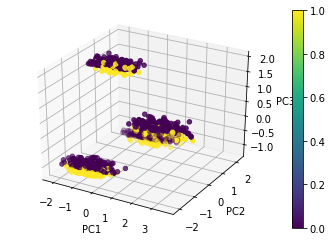

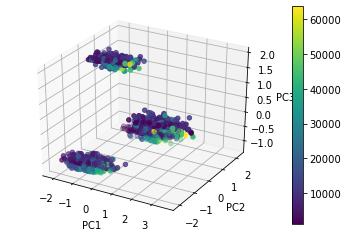

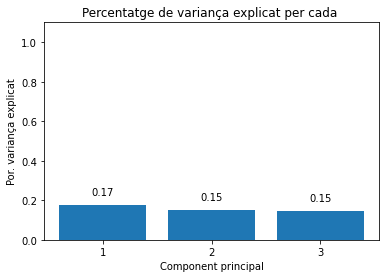

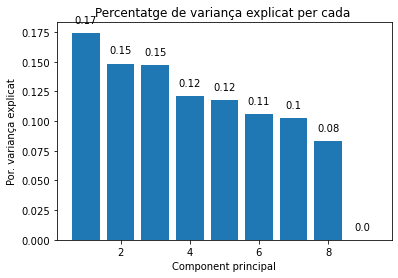

In [58]:
# Es realitza un estudi sobre el PCA
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

model = PCA(n_components=3)
model.fit(X_scaled)
data_pca = pd.DataFrame(
    data = model.components_,
    columns = X.columns,
    index = ['PC1','PC2','PC3'])
X_pca = model.transform(X_scaled)

# Es mira com queda el PCA segons si és fumador
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=X['smoker_yes'])
fig.colorbar(p)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# Es mira com queda el PCA segons la variable resposta
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=Y)
fig.colorbar(p)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# Percentatge de variança de cada component
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(model.n_components_) + 1,
    height = model.explained_variance_ratio_
)

for x, y in zip(np.arange(len(data_pca.columns)) + 1, model.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(model.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Percentatge de variança explicat per cada ')
ax.set_xlabel('Component principal')
ax.set_ylabel('Por. variança explicat');
#SUPER INUTIL, NO EXPLICA RES. AIXÒ ES DEU A QUE LES DADES ESTAN MOLT POC CORRELACIONADES ENTRE ELLES JA DE PER SI

# Generació d'un model amb tots els PCA possibles, per veure quantes dimensions es poden reduïr
model_complet = PCA()
model_complet.fit(X_scaled)

data_pca_complet = pd.DataFrame(
    data = model_complet.components_,
    columns = X.columns,
    index = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(model_complet.n_components_) + 1,
    height = model_complet.explained_variance_ratio_
)

for x, y in zip(np.arange(len(data_pca_complet.columns)) + 1, model_complet.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
ax.set_title('Percentatge de variança explicat per cada ')
ax.set_xlabel('Component principal')
ax.set_ylabel('Por. variança explicat');
plt.show()

## 3. Descens del gradient